<a href="https://colab.research.google.com/github/neuroqudit/pykoppu/blob/main/notebooks/10_seismic_feature_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Seismic Feature Selection with KOPPU

This notebook demonstrates how to solve the Seismic Feature Selection problem using the KOPPU OOS.
The goal is to select an optimal subset of seismic attributes that maximizes relevance to a target property (e.g., porosity) while minimizing redundancy between selected attributes (mRMR approach).

## 1. Problem Formulation

Given $N$ candidate attributes, we want to select exactly $K$ attributes.

**Objective**: Maximize the mRMR score:
$$ \text{Score} = \alpha \sum_{i \in S} R_i - \beta \sum_{i,j \in S} C_{ij} $$

Where:
- $R_i$: Relevance of attribute $i$ to the target.
- $C_{ij}$: Redundancy (correlation) between attributes $i$ and $j$.
- $\alpha, \beta$: Weights for relevance and redundancy.

In [1]:
!pip install pykoppu==0.2.34a0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 28.5 MB/s eta 0:00:00


In [13]:
import sys
import os
import numpy as np

# Ensure we can import the local pykoppu package
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import pykoppu as pk

# 1. Generate Synthetic Data
np.random.seed(42)
n_features = 20
k_select = 5

# Relevance: Random scores between 0 and 1
relevance = np.random.rand(n_features)

# Redundancy: Symmetric matrix with random correlations
# We'll make some high-relevance features highly redundant to test the solver
redundancy = np.random.rand(n_features, n_features) * 0.3 # Base low redundancy
np.fill_diagonal(redundancy, 1.0) # Self-correlation is 1
redundancy = (redundancy + redundancy.T) / 2 # Symmetric

# Introduce a cluster of redundant features (indices 0-4)
# They have high relevance but high redundancy
relevance[0:5] = 0.9
redundancy[0:5, 0:5] = 0.8
np.fill_diagonal(redundancy, 1.0)

# Introduce a diverse set of good features (indices 5-9)
# High relevance, low redundancy
relevance[5:10] = 0.85
redundancy[5:10, 5:10] = 0.1
np.fill_diagonal(redundancy, 1.0)

print(f"Generated {n_features} features. Target k={k_select}.")

Generated 20 features. Target k=5.


## 2. PUBO Mapping

We map this to a QUBO problem:

$$ H = H_{rel} + H_{red} + H_{card} $$

1.  **Relevance**: $H_{rel} = \sum -\alpha R_i x_i$
2.  **Redundancy**: $H_{red} = \sum \beta C_{ij} x_i x_j$
3.  **Cardinality**: $H_{card} = P (\sum x_i - K)^2$

Mapping to OPU...
Solving...
Visualizing OPU Dynamics...


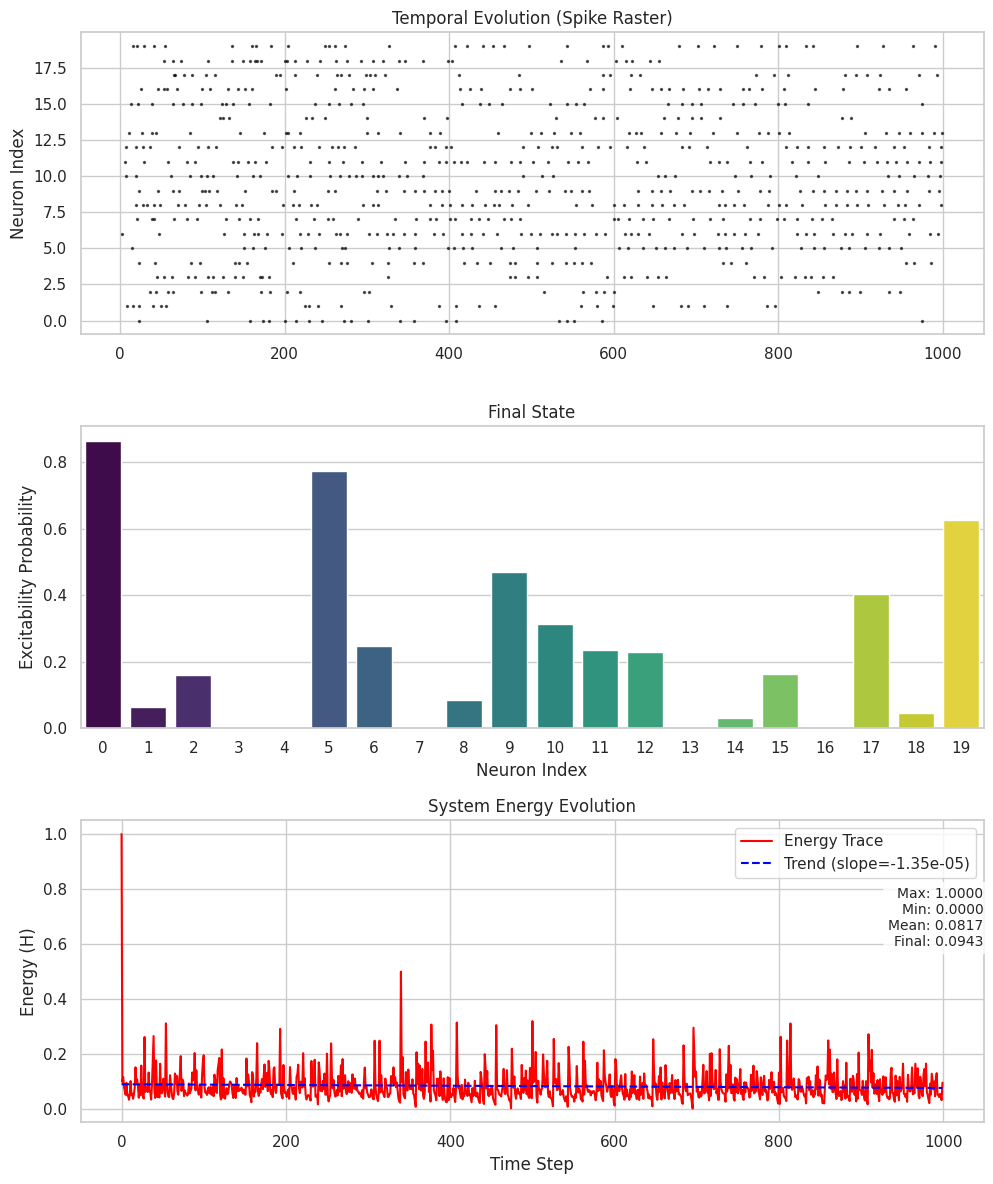

In [14]:
# 2. Create Seismic Feature Selection Problem
print("Mapping to OPU...")
problem = pk.problems.energy.SeismicFeatureSelection(
    relevance=relevance,
    redundancy=redundancy,
    k=k_select,
    alpha=1.0,
    beta=1.0,
    penalty_k=10.0
)

# 3. Solve
print("Solving...")
process = pk.oos.Process(problem, backend='cpu', t=1000)
result = process.run()

# 4. Display OPU Dynamics
print("Visualizing OPU Dynamics...")
result.plot()

## 3. Solution Analysis

We visualize the selected features in the Relevance vs. Redundancy space. Ideal features are in the top-left (High Relevance, Low Redundancy).

Visualizing Solution...


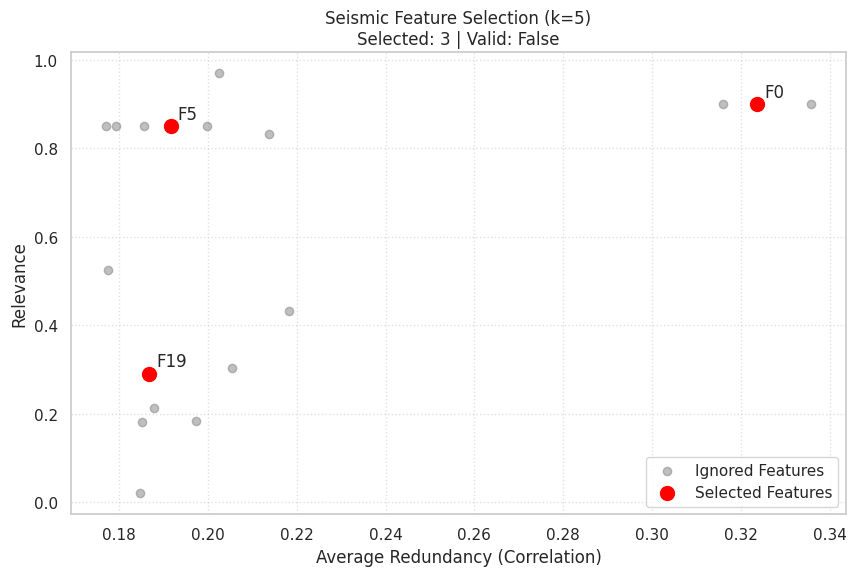


Selected Features: [0, 5, 19]
Count: 3 (Target: 5)
Total Relevance: 2.04
Total Redundancy: 1.20
mRMR Score: 0.84
Valid: False


In [15]:
# 5. Analyse Solution
print("Visualizing Solution...")
problem.plot(result, threshold=0.5)

# Metrics
metrics = problem.evaluate(result.solution)
print(f"\nSelected Features: {metrics['selected_indices']}")
print(f"Count: {metrics['selected_count']} (Target: {metrics['target_k']})")
print(f"Total Relevance: {metrics['total_relevance']:.2f}")
print(f"Total Redundancy: {metrics['total_redundancy']:.2f}")
print(f"mRMR Score: {metrics['mrmr_score']:.2f}")
print(f"Valid: {metrics['valid']}")